In [1]:
import torch
import matplotlib.pyplot as plt
import src.data_utils as dutils
import src.model_utils as mutils
import src.distributions as dist
import torch.nn as nn
%load_ext autoreload
%autoreload 2

embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


Goal: implement simple 1D gaussian location finding example (c.f. Foster paper)

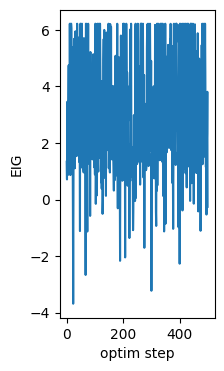

tensor([[[ 0.1772],
         [24.9673]]], grad_fn=<CatBackward0>)


In [66]:
# design network
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,256),
            nn.ReLU(),
            nn.Linear(256,16)
        )
        self.design_dim = 1
        self.y_dim = 1
        self.repr_dim = 16
    def forward(self, xi,y):
        return self.model(torch.cat([xi,y],dim=1))

encoder = Encoder()
emitter = nn.Linear(16,1)
design_network = mutils.Design_Network(encoder,emitter)


# distributions
class Normal_prior(dist.Distr):
    def __init__(self, mu=torch.tensor([0.0]), sigma=torch.tensor([1.0])):
        super().__init__()
        self.distr = torch.distributions.Normal(mu, sigma)

    def sample(self,n):
        return self.distr.sample([n])

    def log_prob(self, thetas):
        return self.distr.log_prob(thetas)

class Squared_distance(dist.Conditional_Distr_multixi):
    def __init__(self, sigma=torch.tensor(0.5), m=torch.tensor(1e-4)):
        super().__init__()
        self.sigma = sigma
        self.m = m
        self.reparam_trick = True

    def sample(self,designs,thetas):
        mus = self.mu(thetas, designs)
        rvs = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))\
            .sample([thetas.shape[0]])
        out = mus + self.sigma * rvs
        return out.reshape((-1,1))
    
    def log_prob(self,ys,designs,thetas):
        mus = self.mu(thetas, designs)
        return torch.distributions.Normal(mus, self.sigma).log_prob(ys.reshape((-1))).reshape(-1,1)
    
    def mu(self, thetas, xis):
        return 1 / (self.m + torch.norm(thetas - xis, dim=1)**2)
        
prior = Normal_prior()
likelihood = Squared_distance()


# train design_network
# torch.autograd.set_detect_anomaly(False)
T = 2
mutils.train_DAD_design_policy(
    T,
    prior,
    likelihood,
    design_network,
    n_simulations=500,
    batch_size=1,
    L = 500,
    print_every=25,
    verbose = 'plot')

# execute design
batch_size = 1
theta_0 = prior.sample(batch_size)
history_xi = []
history_y = []
design_network.reset_buffer(batch_size)
next_xi = torch.zeros((batch_size,design_network.design_dim))
next_y = torch.zeros((batch_size,design_network.y_dim))
for t in range(T):
    next_xi = design_network(next_xi, next_y)
    next_y = likelihood.sample(next_xi, theta_0)
    history_xi.append(next_xi.unsqueeze(1))
    history_y.append(next_y.unsqueeze(1))
history_xi = torch.cat(history_xi, dim=1)  # batch_size x T x design_dim
history_y = torch.cat(history_y, dim=1)    # batch_size x T x y_dim
print(history_xi)